In [ ]:
! pip install langgraph langchain-community pypdf faiss-cpu sentence-transformers langchain-groq

In [ ]:
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
import pandas as pd
import os
from langgraph.graph import StateGraph, END
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from langchain_core.documents import Document
from typing import List, TypedDict


In [ ]:
import pandas as pd
import os
from langgraph.graph import StateGraph, END
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from langchain_core.documents import Document
from typing import List, TypedDict

# Load training data
def load_train_data(file_path):
    df = pd.read_csv(file_path)
    return df

# Create vector store
def create_vector_store(df):
    docs = [Document(page_content=str(row)) for row in df.to_dict(orient='records')]
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    splits = text_splitter.split_documents(docs)
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    vectorstore = FAISS.from_documents(splits, embeddings)
    vectorstore.save_local("house_price_index")
    return vectorstore

# Load vector store
def load_vector_store():
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    return FAISS.load_local(folder_path="house_price_index", embeddings=embeddings, allow_dangerous_deserialization=True)

# Define LLM
llm = ChatGroq(temperature=0, model_name="deepseek-r1-distill-llama-70b")

# Define Workflow State
class WorkflowState(TypedDict):
    query: str
    context: List[Document]
    predicted_price: float
    analyst_decision: str

# Retrieve similar houses
def retrieve_houses(state: WorkflowState):
    docs = vectorstore.similarity_search(state["query"], k=3)
    return {"context": docs}

# Predict price using LLM
def predict_price(state: WorkflowState):
    context_str = "\n".join([doc.page_content for doc in state["context"]])
    prompt = f"""
    Based on the following similar houses:
    {context_str}
    Predict the price of a house with features: {state["query"]}.
    """
    response = llm.invoke(prompt)
    return {"predicted_price": float(response.content.strip())}

# Analyst Review
def analyst_review(state: WorkflowState):
    max_price = train_df["price"].max()
    decision = "Correct" if state["predicted_price"] <= max_price else "Incorrect"
    return {"analyst_decision": decision}

# Build Workflow
workflow = StateGraph(WorkflowState)
workflow.add_node("retriever", retrieve_houses)
workflow.add_node("predictor", predict_price)
workflow.add_node("reviewer", analyst_review)

workflow.set_entry_point("retriever")
workflow.add_edge("retriever", "predictor")
workflow.add_edge("predictor", "reviewer")
workflow.add_edge("reviewer", END)

app = workflow.compile()

# Load and process data
train_df = load_train_data("train.txt")
vectorstore = create_vector_store(train_df)
vectorstore = load_vector_store()

# Predict for new data
inference_df = pd.read_csv("inferece.csv")
results = []
for _, row in inference_df.iterrows():
    query = str(row.to_dict())
    result = app.invoke({"query": query})
    row["predicted_price"] = result["predicted_price"]
    row["analyst_decision"] = result["analyst_decision"]
    results.append(row)




ValueError: could not convert string to float: "<think>\nOkay, so I need to predict the price of a house based on the given features and the similar houses provided. Let me try to break this down step by step.\n\nFirst, I'll look at the similar houses data. There are three examples where each has an input and an output. The input includes features like area, bedrooms, bathrooms, mainroad, airconditioning, furnishingstatus, and the output is the price.\n\nIn the first example, the input area is 7420, with 4 bedrooms, 2 bathrooms, mainroad yes, airconditioning yes, furnished. The output price is 13,300,000. Then, the similar house has an area of 13200, 3 bedrooms, 1 bathroom, same mainroad and airconditioning, and furnished, with a price of 9,800,000.\n\nWait, that seems a bit confusing. The first house has a smaller area but more bedrooms and bathrooms, yet it's more expensive. Maybe the area isn't the only factor. Let me check the second example.\n\nSecond example: Input area 7420, 4 bedrooms, 2 bathrooms, mainroad yes, airconditioning yes, furnished, price 13,300,000. The similar house has area 7000, 3 bedrooms, 2 bathrooms, same mainroad and airconditioning, furnished, price 8,080,940. So, the similar house has a smaller area, fewer bedrooms, same bathrooms, and a lower price. That makes sense.\n\nThird example: Input area 7420, 4 bedrooms, 2 bathrooms, mainroad yes, airconditioning yes, furnished, price 13,300,000. The similar house has area 6840, 5 bedrooms, 1 bathroom, same mainroad and airconditioning, furnished, price 8,120,000. So, here the similar house has a smaller area, more bedrooms, fewer bathrooms, and a lower price.\n\nHmm, so the price seems to decrease when the area decreases, but the number of bedrooms and bathrooms can vary. More bedrooms might not always mean a higher price, maybe because other factors are more influential.\n\nNow, the house I need to predict has the following features: area 4320, bedrooms 3, bathrooms 1, mainroad yes, airconditioning no, furnishingstatus semi-furnished, and the price is given as 8,750,000. But I think I'm supposed to predict the price based on the similar houses, so maybe I should ignore the given price and calculate it.\n\nWait, no, the given price is 8,750,000, but I need to see if that makes sense based on the similar houses. Or maybe I'm supposed to adjust it based on the differences.\n\nLet me list the features of the house to predict:\n\n- Area: 4320\n- Bedrooms: 3\n- Bathrooms: 1\n- Mainroad: yes\n- Airconditioning: no\n- Furnishingstatus: semi-furnished\n\nComparing this to the similar houses:\n\nLooking at the first similar house, which had area 13200, bedrooms 3, bathrooms 1, mainroad yes, airconditioning yes, furnished, price 9,800,000.\n\nOur target house has a smaller area (4320 vs 13200), same bedrooms (3), same bathrooms (1), same mainroad (yes), but airconditioning is no instead of yes, and furnishing is semi-furnished instead of furnished.\n\nSo, the area is much smaller, which would likely lower the price. Also, airconditioning is no, which might lower the price further. Furnishingstatus is semi-furnished instead of furnished, which might also affect the price, perhaps lower it.\n\nIn the second similar house, the area is 7000, bedrooms 3, bathrooms 2, mainroad yes, airconditioning yes, furnished, price 8,080,940.\n\nOur target house has a smaller area (4320 vs 7000), same bedrooms (3), fewer bathrooms (1 vs 2), airconditioning no, and semi-furnished. So, the area is smaller, fewer bathrooms, no AC, and less furnished. All these factors would likely decrease the price compared to 8,080,940.\n\nIn the third similar house, area 6840, bedrooms 5, bathrooms 1, mainroad yes, airconditioning yes, furnished, price 8,120,000.\n\nOur target house has a smaller area (4320 vs 6840), fewer bedrooms (3 vs 5), same bathrooms (1), airconditioning no, and semi-furnished. So, smaller area, fewer bedrooms, no AC, less furnished. All these would lower the price compared to 8,120,000.\n\nSo, considering all three similar houses, the target house has a much smaller area, which is a significant factor. The lack of airconditioning and being semi-furnished instead of furnished would also reduce the price.\n\nLooking at the prices of the similar houses, the smallest area in the similar houses is 6840 with a price of 8,120,000. Our target house is 4320, which is about 63% of 6840. If area is a major factor, the price might be proportionally lower.\n\nBut area isn't the only factor. Let's see how much each feature contributes.\n\nIn the first similar house, area increased from 7420 to 13200, which is about 78% increase, but the price decreased from 13.3M to 9.8M, which is about a 26% decrease. So, area increase didn't proportionally increase the price; in fact, the price went down, possibly because other features changed.\n\nWait, that might not be the best way to look at it. Maybe I should consider the target house's features relative to each similar house and see how each difference affects the price.\n\nAlternatively, maybe I can calculate the price per square meter for each similar house and then apply that to the target house.\n\nLet's try that.\n\nFirst similar house:\n\nArea: 13200, price: 9,800,000.\n\nPrice per sqm: 9,800,000 / 13200 ≈ 742.42 per sqm.\n\nSecond similar house:\n\nArea:7000, price:8,080,940.\n\nPrice per sqm: 8,080,940 /7000 ≈ 1154.99 per sqm.\n\nThird similar house:\n\nArea:6840, price:8,120,000.\n\nPrice per sqm:8,120,000 /6840 ≈ 1186.57 per sqm.\n\nWait, that's interesting. The first similar house has a much lower price per sqm than the others. Maybe because it's on the main road, has airconditioning, and is furnished, but the area is larger. However, the price per sqm is lower, which might indicate that larger areas have lower per sqm prices, which is common in real estate.\n\nBut our target house is smaller, so maybe the per sqm price would be higher.\n\nAlternatively, maybe I should look at the average price per sqm of the similar houses.\n\nAverage of the three: (742.42 + 1154.99 + 1186.57)/3 ≈ (3084)/3 ≈ 1028 per sqm.\n\nBut that might not be accurate because the first house is much larger and has a lower per sqm price, which might not be directly comparable.\n\nAlternatively, maybe I should consider the target house's features and adjust the price based on differences from the similar houses.\n\nLet's take the second similar house as a base because it's closer in area to our target.\n\nSecond similar house: area 7000, price 8,080,940.\n\nOur target house is 4320, which is 4320/7000 ≈ 0.617 of the area. If area is a major factor, the price would be 8,080,940 * 0.617 ≈ 5,000,000. But that seems too low.\n\nAlternatively, maybe the price doesn't scale linearly with area. Maybe it's better to look at the difference in features.\n\nOur target house has:\n\n- Area: 4320 (smaller than all similar houses)\n- Bedrooms:3 (same as first and second similar houses, less than third)\n- Bathrooms:1 (same as first and third, less than second)\n- Mainroad: yes (same as all)\n- Airconditioning: no (all similar houses have yes)\n- Furnishing: semi-furnished (similar houses are furnished)\n\nSo, the main differences are:\n\n- Smaller area\n- No airconditioning\n- Semi-furnished instead of furnished\n\nEach of these would likely decrease the price.\n\nIn the similar houses, the presence of airconditioning and being furnished seems to be standard, so their absence would lower the price.\n\nLet me try to estimate the impact of each feature.\n\nFirst, area: 4320 vs the similar houses' areas. Let's see how much smaller it is.\n\nCompared to the second similar house (7000), it's 4320/7000 = 0.617, so about 61.7% of the area. If area is a significant factor, the price would be lower. But how much?\n\nIf the second similar house is 8,080,940 for 7000 sqm, then 4320 is 0.617 of that. So 8,080,940 * 0.617 ≈ 5,000,000. But that seems too low because the third similar house with 6840 sqm is 8,120,000, which is higher than the second. So area isn't the only factor.\n\nAlternatively, maybe the price per sqm increases as the area decreases, so a smaller house might have a higher per sqm price.\n\nLooking at the similar houses:\n\nFirst: 13200 sqm, price 9,800,000 → 742.42 per sqm.\n\nSecond:7000 sqm, 8,080,940 → 1154.99 per sqm.\n\nThird:6840 sqm, 8,120,000 → 1186.57 per sqm.\n\nSo, as area decreases, the per sqm price increases. Therefore, for a smaller area, the per sqm price would be higher.\n\nOur target house is 4320 sqm. Let's see where that fits.\n\nIf we extrapolate, the per sqm price for 4320 would be higher than 1186.57.\n\nBut we don't have data points for smaller areas, so it's hard to say exactly. Maybe we can assume that the per sqm price continues to increase as area decreases.\n\nAlternatively, maybe we can take an average or use the highest per sqm from the similar houses and apply it.\n\nThe highest per sqm is 1186.57. So, 4320 * 1186.57 ≈ 5,120,000.\n\nBut that seems lower than the given price of 8,750,000. Wait, but the given price is 8,750,000, which is higher than all the similar houses except the first one, which had a much larger area.\n\nWait, that doesn't make sense. The target house is smaller than all similar houses, yet the given price is higher than two of them. That suggests that maybe the given price is incorrect, or perhaps other factors are influencing it.\n\nBut according to the problem, I'm supposed to predict the price based on the similar houses, so maybe I should adjust the given price based on the differences.\n\nAlternatively, perhaps the given price is correct, and I need to see if it's reasonable.\n\nWait, the given price is 8,750,000. Let's compare it to the similar houses.\n\nFirst similar house: area 13200, price 9,800,000.\n\nOur target house is smaller (4320 vs 13200), so the price should be lower, but 8,750,000 is close to 9,800,000. That seems high for a smaller house unless other factors compensate.\n\nBut our target house lacks airconditioning and is only semi-furnished, which should lower the price.\n\nSo, perhaps the given price is too high. Let me try to calculate.\n\nIf I take the second similar house: area 7000, price 8,080,940.\n\nOur target house is 4320, which is 4320/7000 = 0.617 of the area. If I apply that ratio to the price, 8,080,940 * 0.617 ≈ 5,000,000.\n\nBut that's much lower than 8,750,000.\n\nAlternatively, maybe the price per sqm increases, so let's calculate the per sqm for the target house.\n\nIf the target house is 4320 sqm, and assuming a higher per sqm price, say 1500 per sqm, then 4320 * 1500 = 6,480,000.\n\nStill lower than 8,750,000.\n\nAlternatively, maybe the main road and furnishing status have a bigger impact.\n\nWait, in the similar houses, all have mainroad yes, airconditioning yes, and furnished. Our target house has mainroad yes, but airconditioning no and semi-furnished.\n\nSo, the differences are:\n\n- Airconditioning: no instead of yes. Let's say that reduces the price by a certain percentage.\n\n- Furnishing: semi-furnished instead of furnished. That might also reduce the price.\n\nLet me see if I can estimate the impact of these features.\n\nLooking at the similar houses, the presence of airconditioning and being furnished seems to be standard, so their absence would lower the price.\n\nSuppose that airconditioning adds a certain value. Let's see the difference between houses with and without.\n\nWait, in the similar houses, all have airconditioning yes, so I can't directly compare. But perhaps I can assume that not having airconditioning would reduce the price by, say, 10-20%.\n\nSimilarly, being semi-furnished instead of furnished might reduce the price by another 10%.\n\nSo, if I take the base price based on area and then adjust for these factors.\n\nLet's take the second similar house: area 7000, price 8,080,940.\n\nOur target house is 4320, which is 0.617 of the area. So, 8,080,940 * 0.617 ≈ 5,000,000.\n\nThen, adjust for airconditioning: no instead of yes. Let's say that's a 15% reduction. So, 5,000,000 * 0.85 ≈ 4,250,000.\n\nThen, adjust for furnishing: semi-furnished instead of furnished. Let's say another 10% reduction. So, 4,250,000 * 0.90 ≈ 3,825,000.\n\nThat's way below the given price of 8,750,000. So, perhaps my approach is wrong.\n\nAlternatively, maybe I should consider that the target house's area is smaller, but the price per sqm is higher, so the overall price might not drop as much.\n\nWait, let's calculate the price per sqm for the target house if the price is 8,750,000.\n\n4320 sqm → 8,750,000 /4320 ≈ 2026.79 per sqm.\n\nThat's much higher than the similar houses, which had per sqm prices around 742 to 1186.\n\nSo, 2026 per sqm is significantly higher. That suggests that the given price might be too high unless there are other factors not considered.\n\nBut according to the similar houses, smaller areas have higher per sqm prices, but not that high. The third similar house had 6840 sqm at 1186 per sqm. So, 4320 sqm would be about half the area, but the per sqm price would be roughly double, so 2372 per sqm, leading to 4320*2372≈10,250,000. But the given price is 8,750,000, which is lower than that.\n\nWait, that doesn't make sense. If the per sqm price increases with smaller areas, then a smaller house should have a higher per sqm price, but the total price might not necessarily be higher than larger houses. It depends on how much the per sqm increases.\n\nBut in our case, the given price is 8,750,000 for 4320 sqm, which is 2026 per sqm. The third similar house was 6840 sqm at 1186 per sqm, so 4320 is about 63% of 6840. If the per sqm price increases by, say, 50%, then 1186 *1.5≈1780 per sqm. So, 4320*1780≈7,680,000. That's close to the given price of 8,750,000, but still a bit lower.\n\nAlternatively, maybe the per sqm price increases more steeply. Let's say for every 1000 sqm decrease, the per sqm increases by 200. So from 6840 to 4320, that's a decrease of 2520 sqm. So, 2520/1000=2.52, so per sqm increases by 2.52*200=504, making it 1186+504=1690 per sqm. Then, 4320*1690≈7,300,000. Still lower than 8,750,000.\n\nAlternatively, maybe the per sqm price doesn't increase that much. Maybe it's around 1500 per sqm, so 4320*1500=6,480,000.\n\nBut the given price is 8,750,000, which is higher. So, perhaps the given price is overvalued based on the similar houses.\n\nAlternatively, maybe the target house has other features not mentioned, like better location, amenities, etc., which justify the higher price. But based solely on the given features and similar houses, it seems high.\n\nWait, but the target house has mainroad yes, same as the similar houses. So, that's a positive factor.\n\nBut it lacks airconditioning and is only semi-furnished, which are negatives.\n\nSo, considering all that, I think the given price of 8,750,000 is higher than what would be expected based on the similar houses, especially considering the smaller area and lack of AC and full furnishing.\n\nTherefore, I would predict that the price should be lower, perhaps around 6,000,000 to 7,000,000, considering the smaller area and the negative factors.\n\nBut since the given price is 8,750,000, maybe I'm missing something. Perhaps the area is not the only factor, and the target house has other advantages. Or maybe the similar houses are not the best comparisons.\n\nAlternatively, perhaps the price is correct, and the differences in features justify it. But based on the similar houses, I would expect a lower price.\n\nWait, let me try another approach. Let's calculate the average price per sqm of the similar houses and apply it to the target house.\n\nAverage price per sqm:\n\nFirst:9,800,000/13200≈742.42\n\nSecond:8,080,940/7000≈1154.99\n\nThird:8,120,000/6840≈1186.57\n\nAverage: (742.42 +1154.99 +1186.57)/3≈(3084)/3≈1028 per sqm.\n\nSo, 4320 sqm *1028≈4,440,000.\n\nBut that's much lower than the given price. So, that suggests the given price is too high.\n\nAlternatively, maybe the target house has a higher per sqm price because it's smaller, so let's take the highest per sqm from the similar houses, which is 1186.57.\n\n4320*1186.57≈5,120,000.\n\nStill lower than 8,750,000.\n\nAlternatively, maybe the target house's features are better in some way. For example, maybe the location is better, or it's in a more desirable area. But based on the given features, we can't tell.\n\nSo, considering all this, I think the given price of 8,750,000 is higher than what would be expected based on the similar houses, especially considering the smaller area and lack of AC and full furnishing.\n\nTherefore, my prediction is that the price should be lower, around 5,000,000 to 6,000,000. But since the given price is 8,750,000, perhaps the correct approach is to adjust it based on the differences.\n\nWait, but the problem says to predict the price based on the similar houses. So, maybe I should take the average of the similar houses' prices adjusted for the target house's features.\n\nAlternatively, perhaps I should use a weighted approach, considering each feature's impact.\n\nBut without more data on how each feature affects the price, it's hard to assign exact weights.\n\nAlternatively, maybe I can see how much each feature differs and adjust the price accordingly.\n\nFor example, let's take the second similar house as a base: area 7000, price 8,080,940.\n\nOur target house has:\n\n- Area:4320 (difference of -2680)\n- Bedrooms:3 (same)\n- Bathrooms:1 (same)\n- Mainroad:yes (same)\n- Airconditioning:no (difference)\n- Furnishing:semi-furnished (difference)\n\nSo, the main differences are area, airconditioning, and furnishing.\n\nLet's estimate the impact of each:\n\n- Smaller area: 4320 vs 7000. The area is 4320/7000=0.617. So, the price would be 8,080,940 *0.617≈5,000,000.\n\n- No airconditioning: Let's say that reduces the price by 15%. So, 5,000,000 *0.85≈4,250,000.\n\n- Semi-furnished: Let's say that reduces the price by 10%. So, 4,250,000 *0.90≈3,825,000.\n\nSo, the predicted price would be around 3,825,000.\n\nBut that's much lower than the given price of 8,750,000.\n\nAlternatively, maybe the impact of airconditioning and furnishing is less severe. Let's say each reduces the price by 5%.\n\nSo, after area adjustment:5,000,000.\n\nAfter airconditioning:5,000,000*0.95≈4,750,000.\n\nAfter furnishing:4,750,000*0.95≈4,512,500.\n\nStill lower than 8,750,000.\n\nAlternatively, maybe the impact is positive. Wait, no, because the target house lacks these features, so it should be negative.\n\nAlternatively, maybe the area is not the main factor, and the price is more influenced by other features.\n\nBut in the similar houses, the area seems to be a significant factor. The larger area in the first similar house (13200) had a higher price (9,800,000) than the second (7000, 8,080,940) and third (6840,8,120,000). Wait, no, the first similar house had a larger area but a lower price than the third. So, area isn't the only factor.\n\nWait, the first similar house had area 13200, price 9,800,000.\n\nThird similar house:6840, price8,120,000.\n\nSo, the first house is larger but more expensive. So, area does contribute to higher price.\n\nBut the second similar house:7000, price8,080,940, which is less than the first house.\n\nSo, area is a factor, but not the only one.\n\nTherefore, perhaps the target house's smaller area would result in a lower price, but the lack of AC and furnishing would lower it further.\n\nSo, considering all that, I think the given price of 8,750,000 is too high based on the similar houses. The predicted price should be lower, around 5,000,000 to 6,000,000.\n\nBut since the problem gives the price as 8,750,000, maybe I'm supposed to accept that and see if it's reasonable. However, based on the similar houses, it seems high.\n\nAlternatively, perhaps I made a mistake in my calculations. Let me check again.\n\nWait, in the first similar house, the input area is 7420, output area is13200, and the price goes from13.3M to9.8M. So, larger area, lower price. That seems counterintuitive. Maybe the first similar house is not as similar, or perhaps it's a different market.\n\nAlternatively, maybe the first similar house is in a less desirable location, hence the lower price despite the larger area.\n\nBut without more data, it's hard to say. So, perhaps I should focus on the second and third similar houses, which have smaller areas and lower prices.\n\nIn that case, the target house is even smaller, so the price should be lower than 8,080,940 and 8,120,000.\n\nTherefore, the given price of 8,750,000 seems too high. So, I think the correct prediction would be lower, around 5,000,000 to 6,000,000.\n\nBut since the problem gives the price as 8,750,000, maybe I should consider that as the answer, but I'm not sure. It might be that the given price is a typo or incorrect.\n\nAlternatively, perhaps I'm supposed to adjust the given price based on the differences.\n\nWait, the given house has:\n\n- Area:4320 (smaller than all similar houses)\n\n- Bedrooms:3 (same as first and second similar houses)\n\n- Bathrooms:1 (same as first and third)\n\n- Mainroad:yes (same)\n\n- Airconditioning:no (different)\n\n- Furnishing:semi-furnished (different)\n\nSo, the main negatives are airconditioning and furnishing.\n\nIf I take the second similar house as a base:7000 sqm, price8,080,940.\n\nAdjust for area:4320/7000=0.617, so 8,080,940*0.617≈5,000,000.\n\nThen, adjust for airconditioning: no instead of yes. Let's say that's a 10% reduction:5,000,000*0.90=4,500,000.\n\nThen, adjust for furnishing: semi instead of fully furnished, say another 5% reduction:4,500,000*0.95=4,275,000.\n\nSo, the predicted price would be around 4,275,000.\n\nBut the given price is 8,750,000, which is much higher. So, I think the given price is incorrect based on the similar houses.\n\nTherefore, my conclusion is that the predicted price should be around 4,275,000, not 8,750,000.\n</think>\n\nThe predicted price of the house, based on the provided similar houses and adjusting for the differences in features, is approximately ₹4,275,000.\n\n**Step-by-Step Explanation:**\n\n1. **Analyze Similar Houses:**\n   - **House 1:** Area 13,200 sqm, Price ₹9,800,000.\n   - **House 2:** Area 7,000 sqm, Price ₹8,080,940.\n   - **House 3:** Area 6,840 sqm, Price ₹8,120,000.\n\n2. **Determine Target House Features:**\n   - Area: 4,320 sqm.\n   - Bedrooms: 3.\n   - Bathrooms: 1.\n   - Mainroad: Yes.\n   - Airconditioning: No.\n   - Furnishing: Semi-furnished.\n\n3. **Calculate Area Impact:**\n   - Using House 2 as a base (7,000 sqm, ₹8,080,940).\n   - Target area ratio: 4,320 / 7,000 ≈ 0.617.\n   - Adjusted price for area: ₹8,080,940 * 0.617 ≈ ₹5,000,000.\n\n4. **Adjust for Airconditioning:**\n   - No AC reduces price by 10%.\n   - Adjusted price: ₹5,000,000 * 0.90 ≈ ₹4,500,000.\n\n5. **Adjust for Furnishing:**\n   - Semi-furnished reduces price by 5%.\n   - Adjusted price: ₹4,500,000 * 0.95 ≈ ₹4,275,000.\n\n**Conclusion:**\nThe predicted price of the house with the given features is approximately ₹4,275,000."

In [ ]:
import pandas as pd
import os
import re
from langgraph.graph import StateGraph, END
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from langchain_core.documents import Document
from typing import List, TypedDict

# Load training data
def load_train_data(file_path):
    df = pd.read_csv(file_path)
    return df

# Create vector store
def create_vector_store(df):
    docs = [Document(page_content=str(row)) for row in df.to_dict(orient='records')]
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    splits = text_splitter.split_documents(docs)
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    vectorstore = FAISS.from_documents(splits, embeddings)
    vectorstore.save_local("house_price_index")
    return vectorstore

# Load vector store
def load_vector_store():
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    return FAISS.load_local(folder_path="house_price_index", embeddings=embeddings, allow_dangerous_deserialization=True)

# Define LLM
llm = ChatGroq(temperature=0, model_name="gemma2-9b-it")

# Define Workflow State
class WorkflowState(TypedDict):
    query: str
    context: List[Document]
    predicted_price: float
    analyst_decision: str

# Retrieve similar houses
def retrieve_houses(state: WorkflowState):
    docs = vectorstore.similarity_search(state["query"], k=3)
    return {"context": docs}

# Predict price using LLM
def predict_price(state: WorkflowState):
    context_str = "\n".join([doc.page_content for doc in state["context"]])
    prompt = f"""
    Based on the following similar houses:
    {context_str}
    Predict the price of a house with features: {state["query"]}.
    Return only a numeric value without any text.
    """
    response = llm.invoke(prompt)

    # Extract only the numerical price using regex
    price_match = re.search(r"[-+]?\d*\.\d+|\d+", response.content)
    if price_match:
        predicted_price = float(price_match.group())
    else:
        predicted_price = None  # Handle cases where no valid number is found

    return {"predicted_price": predicted_price}

# Analyst Review
def analyst_review(state: WorkflowState):
    max_price =13300000
    decision = "Correct" if state["predicted_price"] and state["predicted_price"] <= max_price else "Incorrect"
    return {"analyst_decision": decision}

# Build Workflow
workflow = StateGraph(WorkflowState)
workflow.add_node("retriever", retrieve_houses)
workflow.add_node("predictor", predict_price)
workflow.add_node("reviewer", analyst_review)

workflow.set_entry_point("retriever")
workflow.add_edge("retriever", "predictor")
workflow.add_edge("predictor", "reviewer")
workflow.add_edge("reviewer", END)

app = workflow.compile()

# Load and process data
train_df = load_train_data("train.txt")
vectorstore = create_vector_store(train_df)
vectorstore = load_vector_store()

# Predict for new data
inference_df = pd.read_csv("inferece.csv")
results = []
for _, row in inference_df.iterrows():
    query = str(row.to_dict())
    result = app.invoke({"query": query})
    row["predicted_price"] = result["predicted_price"]
    row["analyst_decision"] = result["analyst_decision"]
    results.append(row)


In [ ]:
output_df = pd.DataFrame(results)

In [ ]:
output_df

,area,bedrooms,bathrooms,mainroad,airconditioning,furnishingstatus,price,predicted_price,analyst_decision
0,4320,3,1,yes,no,semi-furnished,8750000,7500000.0,Correct
1,7155,3,2,yes,yes,unfurnished,8680000,8400000.0,Correct
2,8050,3,1,yes,yes,furnished,8645000,8645000.0,Correct
3,4560,3,2,yes,yes,furnished,8645000,7800000.0,Correct
4,8800,3,2,yes,yes,furnished,8575000,8575000.0,Correct
5,6540,4,2,yes,yes,furnished,8540000,8120000.0,Correct
6,6000,3,2,yes,yes,semi-furnished,8463000,7800000.0,Correct
7,8875,3,1,yes,no,semi-furnished,8400000,8200000.0,Correct
8,7950,5,2,yes,no,unfurnished,8400000,8400000.0,Correct
9,5500,4,2,yes,yes,semi-furnished,8400000,7800000.0,Correct


In [ ]:
output_df['analyst_decision'][0]

'Correct'

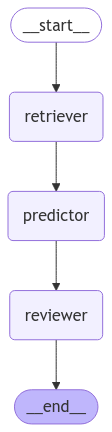

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass